<a href="https://colab.research.google.com/github/Alban998/buildWithAI/blob/main/Th%C3%A8me_2_prise_en_main_de_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importation des bibliothèques**





In [ ]:
# ==============================================================
# 1. Importation des bibliothèques
# ==============================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Pour la reproductibilité
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

**Entrainement**

Train dataset: (2922, 3)


,Date,Rainfall,Runoff
0,1,0.0,82.03
1,2,0.0,68.26
2,3,0.0,72.53
3,4,0.0,76.56
4,5,14.4,126.97


X_train_seq: (2921, 1, 1) | y_train_seq: (2921,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 10)          │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331 (5.20 KB)

 Trainable params: 1,331 (5.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.9300
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8181
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7993
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8245
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7436
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7490
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7978
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7252
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8195
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8052


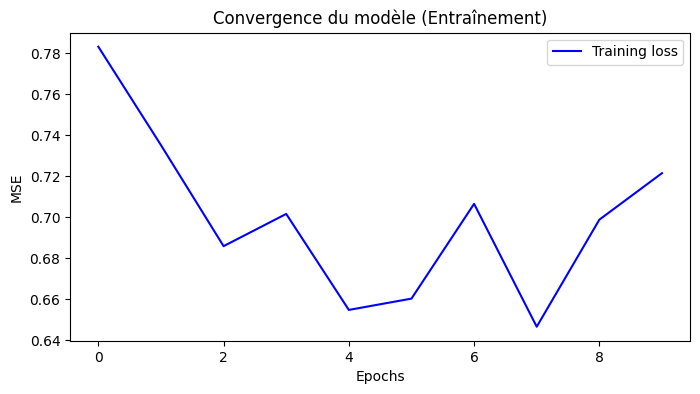

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

 Training Results:
RMSE : 206.335
MAE  : 77.269
R²   : 0.356
NSE  : 0.356


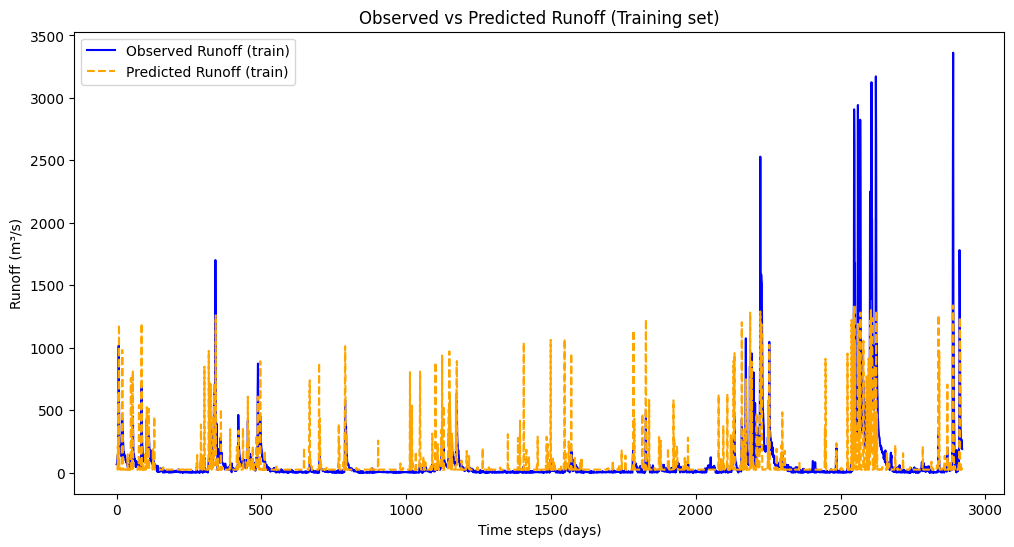

In [ ]:
 # ==============================================================
# 2. Lecture et préparation du jeu d’entraînement
# ==============================================================
df_train = pd.read_excel(r'/content/Entrainement.xlsx')
df_train = df_train[['Date', 'Rainfall', 'Runoff']]

print("Train dataset:", df_train.shape)
display(df_train.head())

X_train = df_train[['Rainfall']]
y_train = df_train[['Runoff']]


# ==============================================================
# 3. Normalisation des données
# ==============================================================
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)


# ==============================================================
# 4. Création des séquences temporelles (fenêtres glissantes)
# ==============================================================
hops = 1 #<===ICI HOPS

X_seq, y_seq = [], []
for i in range(hops, len(X_train_scaled)):
    X_seq.append(X_train_scaled[i-hops:i, :])
    y_seq.append(y_train_scaled[i, 0])

X_train_seq = np.array(X_seq)
y_train_seq = np.array(y_seq)

print("X_train_seq:", X_train_seq.shape, "| y_train_seq:", y_train_seq.shape)


# ==============================================================
# 5. Construction du modèle LSTM
# ==============================================================
model = Sequential([
    LSTM(10, return_sequences=True, input_shape=(hops, X_train_seq.shape[2])), #<===ICI Construction du modèle LSTM
    Dropout(0.3),
    LSTM( 10, return_sequences=False),
    Dropout(0.4),
    Dense(1)
])

adam = optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=adam, loss='mean_squared_error')
model.summary()


# ==============================================================
# 6. Entraînement du modèle
# ==============================================================
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=10,
    batch_size= 32,
    verbose=1,
    callbacks=[es]
)


# ==============================================================
# 7. Visualisation de la convergence
# ==============================================================
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('Convergence du modèle (Entraînement)')
plt.show()


# ==============================================================
# 8. Prédiction et évaluation sur l’ensemble d’entraînement
# ==============================================================
y_train_pred_scaled = model.predict(X_train_seq)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_train_true = y_train.iloc[hops:].values.reshape(-1,1)

rmse_train = sqrt(mean_squared_error(y_train_true, y_train_pred))
mae_train  = mean_absolute_error(y_train_true, y_train_pred)
r2_train   = r2_score(y_train_true, y_train_pred)
nse_train  = 1 - (np.sum((y_train_true - y_train_pred)**2) / np.sum((y_train_true - np.mean(y_train_true))**2))

print("\n Training Results:")
print(f"RMSE : {rmse_train:.3f}")
print(f"MAE  : {mae_train:.3f}")
print(f"R²   : {r2_train:.3f}")
print(f"NSE  : {nse_train:.3f}")

# Visualisation
plt.figure(figsize=(12,6))
plt.plot(y_train_true, label='Observed Runoff (train)', color='blue')
plt.plot(y_train_pred, label='Predicted Runoff (train)', color='orange', linestyle='--')
plt.xlabel('Time steps (days)')
plt.ylabel('Runoff (m³/s)')
plt.legend()
plt.title('Observed vs Predicted Runoff (Training set)')
plt.show()


**Test**

Test dataset: (365, 3)


,Date,Rainfall,Runoff
0,1,0.0,47.70
1,2,0.0,35.16
2,3,0.0,54.99
3,4,0.0,5.17
4,5,0.0,35.51


X_test_seq: (364, 1, 1) | y_test_seq: (364,)
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

 Test Results (no data leakage):
RMSE : 247.425
MAE  : 114.014
R²   : 0.202
NSE  : 0.202


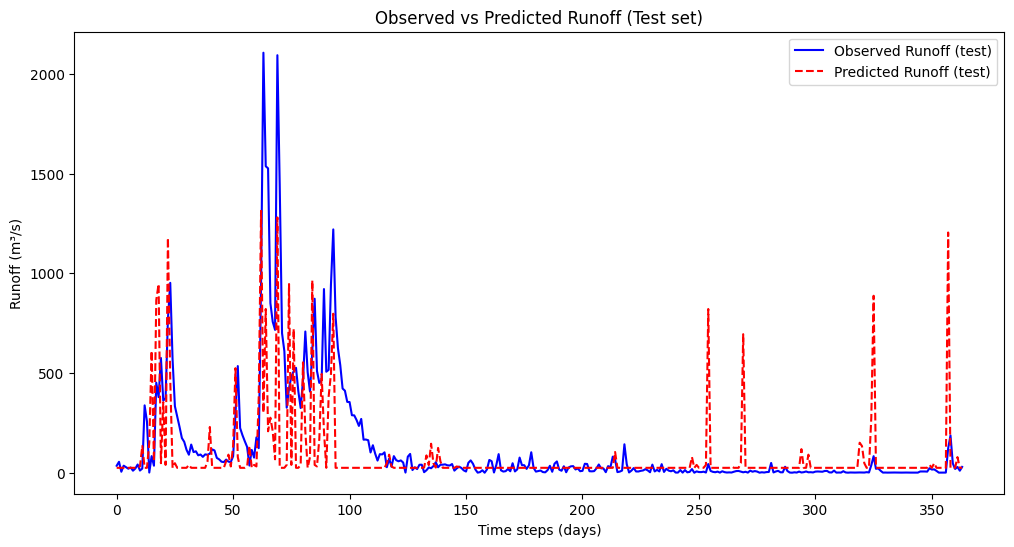

,Dataset,RMSE,MAE,R²,NSE
0,Training,206.334815,77.269455,0.356068,0.356068
1,Test,247.425059,114.013773,0.202050,0.202050



📂 Fichiers exportés :
 - LSTM_Training_Predictions.xlsx
 - LSTM_Test_Predictions.xlsx
 - LSTM_Metrics.xlsx


In [ ]:
#==============================================================
# 9. Lecture et préparation du jeu de TEST
# ==============================================================
df_test = pd.read_excel(r'/content/Test.xlsx')
df_test = df_test[['Date', 'Rainfall', 'Runoff']]

print("Test dataset:", df_test.shape)
display(df_test.head())

# Normalisation avec les scalers du TRAIN uniquement
X_test_scaled = scaler_X.transform(df_test[['Rainfall']])
y_test_scaled = scaler_y.transform(df_test[['Runoff']])

# Création des séquences
X_test_seq, y_test_seq = [], []
for i in range(hops, len(X_test_scaled)):
    X_test_seq.append(X_test_scaled[i-hops:i, :])
    y_test_seq.append(y_test_scaled[i, 0])

X_test_seq = np.array(X_test_seq)
y_test_seq = np.array(y_test_seq)

print("X_test_seq:", X_test_seq.shape, "| y_test_seq:", y_test_seq.shape)


# ==============================================================
# 10. Prédiction et évaluation sur le TEST
# ==============================================================
y_test_pred_scaled = model.predict(X_test_seq)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_true = df_test['Runoff'].iloc[hops:].values.reshape(-1,1)

rmse_test = sqrt(mean_squared_error(y_test_true, y_test_pred))
mae_test  = mean_absolute_error(y_test_true, y_test_pred)
r2_test   = r2_score(y_test_true, y_test_pred)
nse_test  = 1 - (np.sum((y_test_true - y_test_pred)**2) / np.sum((y_test_true - np.mean(y_test_true))**2))

print("\n Test Results (no data leakage):")
print(f"RMSE : {rmse_test:.3f}")
print(f"MAE  : {mae_test:.3f}")
print(f"R²   : {r2_test:.3f}")
print(f"NSE  : {nse_test:.3f}")


# ==============================================================
# 11. Visualisation des résultats de TEST
# ==============================================================
plt.figure(figsize=(12,6))
plt.plot(y_test_true, label='Observed Runoff (test)', color='blue')
plt.plot(y_test_pred, label='Predicted Runoff (test)', color='red', linestyle='--')
plt.xlabel('Time steps (days)')
plt.ylabel('Runoff (m³/s)')
plt.legend()
plt.title('Observed vs Predicted Runoff (Test set)')
plt.show()


# ==============================================================
# 12. Exportation des résultats
# ==============================================================
train_results = pd.DataFrame({
    'Runoff_Observed': y_train_true.flatten(),
    'Runoff_Predicted': y_train_pred.flatten()
})
train_results.to_excel(r'LSTM_Training_Predictions.xlsx', index=False)

test_results = pd.DataFrame({
    'Runoff_Observed': y_test_true.flatten(),
    'Runoff_Predicted': y_test_pred.flatten()
})
test_results.to_excel(r'LSTM_Test_Predictions.xlsx', index=False)

metrics = pd.DataFrame({
    'Dataset': ['Training', 'Test'],
    'RMSE': [rmse_train, rmse_test],
    'MAE': [mae_train, mae_test],
    'R²': [r2_train, r2_test],
    'NSE': [nse_train, nse_test]
})
metrics.to_excel(r'LSTM_Metrics.xlsx', index=False)
display(metrics)

print("\n📂 Fichiers exportés :")
print(" - LSTM_Training_Predictions.xlsx")
print(" - LSTM_Test_Predictions.xlsx")
print(" - LSTM_Metrics.xlsx")